<h1><center> Dimension Reduction </center></h1>

In [2]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from textwrap import wrap

# Change cell width to fullscreen (like colab)
# https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))

In [3]:
# Bold font for plots
from matplotlib import rc,rcParams
rc('font', weight='bold')
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams.update({'font.size': 18})
# rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']

In [4]:
def read_data(f_path, variable_list):
    dataset = pd.read_excel(f_path)
    column_names = dataset.columns

    # Change treatment title - optional
    dataset.rename(columns={'Treated (HIP/Y/N)':'Treatment Information'}, inplace=True)
    dataset.rename(columns={'Cell Spacing':'Cell Spacing (um)'}, inplace=True)
    column_names = dataset.columns
    # Change (um) to correct scientific symbol
    dataset.columns = [str.replace('(um)', '(\u03BCm)') for str in column_names]
    dataset = dataset.replace(r'\s+', np.nan, regex =True)

    # Searches selected variable's index number
    col_index = []
    for i in range(len(variable_list)): 
        col_index.append(column_names.get_loc(variable_list[i]))
    # Change (um) to correct scientific symbol
    variable_list = [str.replace('(um)', '(\u03BCm)') for str in variable_list]
    #col_index.append(column_names.get_loc(variable_list[i]))
    # Converts whole dataset to df and filters necessary columns 
    dataset = dataset[dataset.columns[col_index]]

    return dataset

In [5]:
# Specify list of variables we want in our dataframe
col_var = ['Material',
            'Laser Power (W)',
            'Scanning Speed (mm/s)',
            'Layer Thickness (um)',
            'Hatch Spacing (um)',
            'Volumetric energy density (J/mm3)',
            'Treatment Information',
            'Yield Stress (MPa)',
            'Ultimate Tensile Stress (MPa)', 
            'Elongation (%)',
            'Consolidation (%)',
            'Average Work Hardening'
            ]

path = r'/Users/rww21/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Year 3/Code/Data Analytics Paper/Process Parameters and Properties LPBF - New.xlsx'

dataset = read_data(path, col_var)
# Filter data to specified materials
materials_list = ['316L', 'IN718', 'TI6Al4V', 'AlSi10Mg']
dataset = dataset[dataset['Material'].isin(materials_list)]
dataset = dataset.reset_index(drop=True)
dataset

/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_26346/2864843566.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = dataset.replace(r'\s+', np.nan, regex =True)


,Material,Laser Power (W),Scanning Speed (mm/s),Layer Thickness (μm),Hatch Spacing (μm),Volumetric energy density (J/mm3),Treatment Information,Yield Stress (MPa),Ultimate Tensile Stress (MPa),Elongation (%),Consolidation (%),Average Work Hardening
0,IN718,110.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,74.50,NaN
1,IN718,110.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.00,NaN
2,IN718,120.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92.00,NaN
3,IN718,130.0,400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98.40,NaN
4,IN718,180.0,600.0,30.0,150.0,NaN,NaN,804.0,1076.5,16.85,98.67,16.172107
...,...,...,...,...,...,...,...,...,...,...,...,...
2687,316L,350.0,1700.0,80.0,25.0,102.941176,NaN,366.9,523.7,48.00,98.08,3.266667
2688,316L,100.0,1700.0,55.0,35.0,30.557678,NaN,137.2,165.4,8.00,80.99,3.525000
2689,316L,200.0,1700.0,55.0,35.0,61.115355,NaN,315.9,332.2,9.00,92.21,1.811111
2690,316L,350.0,1400.0,55.0,35.0,129.870130,NaN,398.8,551.2,58.00,99.27,2.627586


In [6]:
# Choose variables to consider (for input and output data)
input_var = ['Material',
            'Laser Power (W)',
            'Scanning Speed (mm/s)',
            'Layer Thickness (μm)',
            'Hatch Spacing (μm)']

output_var = ['Yield Stress (MPa)',
              'Average Work Hardening',
              'Elongation (%)',
              'Consolidation (%)']

# Obtains length of input and outputs
n_inputs = len(input_var)
n_outputs = len(output_var)

# Preprocessing Data

In [7]:
# Consider materials - Uses OneHotEncoder (encoding materials and heat treatment) without Iterative Imputer (missing values)
x_df = dataset[input_var].drop(columns=['Material'])
x_df = x_df.dropna()
x_df_index = x_df.index.to_list()

# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_df)

total_data = len(dataset)
remain_data = x_scaled.shape[0]
dropped_data = len(dataset) - remain_data
print(" Total data = ", total_data, "\n", "Dropped data = ", dropped_data, "\n", "Remaining data = ", remain_data)

 Total data =  2692 
 Dropped data =  522 
 Remaining data =  2170


# PCA Transformation

In [7]:
pca = PCA(n_components=2)  # Adjust the number of components according to your requirement
x_pca = pca.fit_transform(x_scaled)

print("Original shape: {}".format(str(x_scaled.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))

Original shape: (2170, 4)
Reduced shape: (2170, 2)


In [8]:
output_df = dataset.loc[x_df_index].reset_index(drop=True)
output_df = output_df[output_var]
output_df

,Yield Stress (MPa),Average Work Hardening,Elongation (%),Consolidation (%)
0,804.0,16.172107,16.85,98.67
1,800.5,13.040380,21.05,98.85
2,770.5,13.154362,22.35,99.10
3,772.5,11.584158,25.25,99.12
4,NaN,NaN,NaN,95.00
...,...,...,...,...
2165,366.9,3.266667,48.00,98.08
2166,137.2,3.525000,8.00,80.99
2167,315.9,1.811111,9.00,92.21
2168,398.8,2.627586,58.00,99.27


In [9]:
pca_colname = ['Principal Component 1', 'Principal Component 2']
pca_df = pd.DataFrame(x_pca, columns=pca_colname)
pca_df

,Principal Component 1,Principal Component 2
0,-0.127649,-0.644594
1,-0.127649,-0.644594
2,-0.127649,-0.644594
3,-0.127649,-0.644594
4,-0.863123,0.683204
...,...,...
2165,0.478911,1.479227
2166,-0.863928,1.066354
2167,-0.525085,1.324492
2168,-0.026583,1.224963


# Correlation Maps

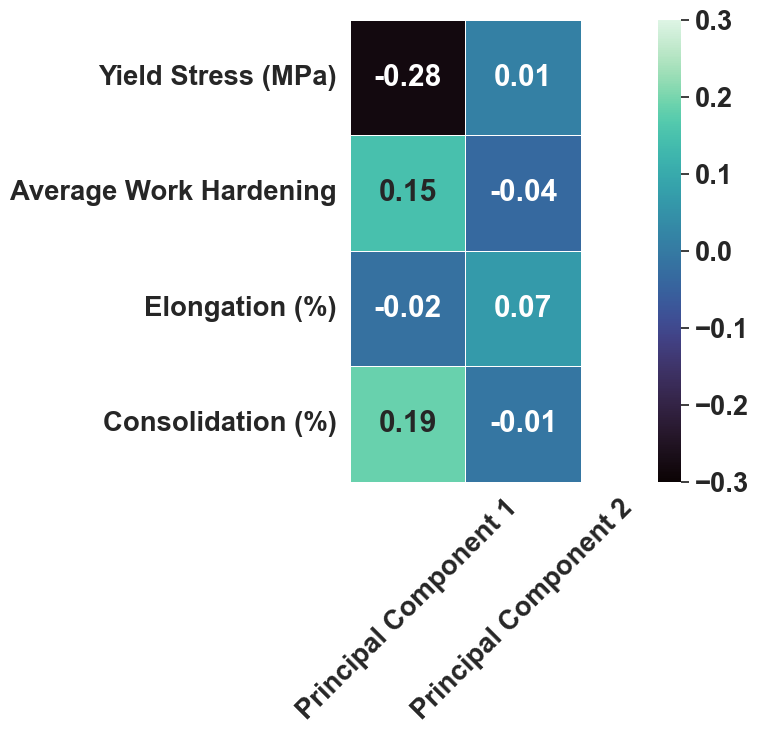

In [10]:
# Spearman's Correlation Coefficient
all_df = pd.concat([pca_df, output_df], axis=1)
all_df = all_df.corr('spearman')
all_df = all_df.drop(pca_colname)
all_df = all_df.drop(output_var, axis=1)

sns.set(font_scale=1.8)
plt.figure(figsize=(20, 6))
cmap = sns.color_palette("mako", as_cmap=True)
heatmap = sns.heatmap(all_df, vmin=-0.3, vmax=0.3, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', cmap=cmap)

labels_x = [ '\n'.join(wrap(l, 17)) for l in output_var]
# heatmap.set_xticklabels(labels_x);
plt.xticks(rotation=45)
plt.yticks(rotation=0);

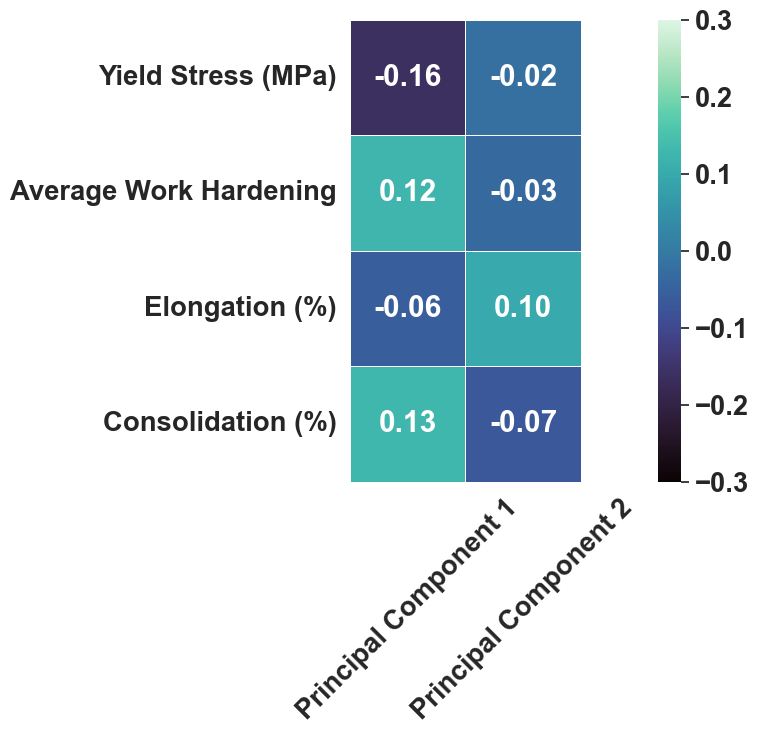

In [11]:
# Pearson's Correlation Coefficient
all_df = pd.concat([pca_df, output_df], axis=1)
all_df = all_df.corr('pearson')
all_df = all_df.drop(pca_colname)
all_df = all_df.drop(output_var, axis=1)

sns.set(font_scale=1.8)
plt.figure(figsize=(20, 6))
cmap = sns.color_palette("mako", as_cmap=True)
heatmap = sns.heatmap(all_df, vmin=-0.3, vmax=0.3, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', cmap=cmap)

labels_x = [ '\n'.join(wrap(l, 17)) for l in output_var]
# heatmap.set_xticklabels(labels_x);
plt.xticks(rotation=45)
plt.yticks(rotation=0);

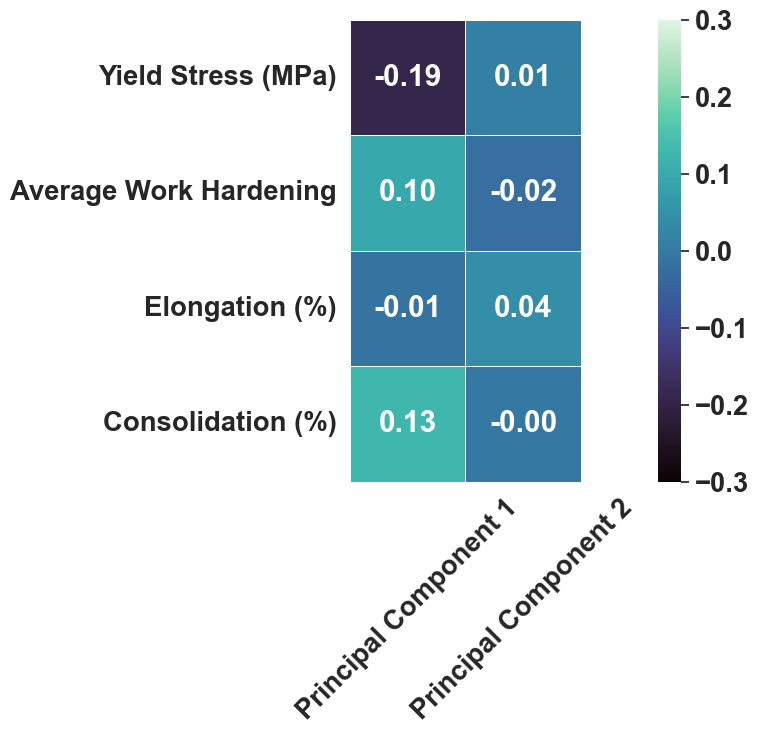

In [12]:
# Kendall's Correlation Coefficient
all_df = pd.concat([pca_df, output_df], axis=1)
all_df = all_df.corr('kendall')
all_df = all_df.drop(pca_colname)
all_df = all_df.drop(output_var, axis=1)

sns.set(font_scale=1.8)
plt.figure(figsize=(20, 6))
cmap = sns.color_palette("mako", as_cmap=True)
heatmap = sns.heatmap(all_df, vmin=-0.3, vmax=0.3, center=0,
            square=True, linewidths=.5, annot=True, fmt='.2f', cmap=cmap)

labels_x = [ '\n'.join(wrap(l, 17)) for l in output_var]
# heatmap.set_xticklabels(labels_x);
plt.xticks(rotation=45)
plt.yticks(rotation=0);

In [13]:
def in_out_corr(df_x, df_y, input_params, output_params, method):
    all_df = pd.concat([df_x, df_y], axis=1)
    all_df = all_df.replace(r'\s+', np.nan, regex = True)
    all_df = all_df.corr(method)
    all_df = all_df.drop(index=input_params)
    all_df = all_df.drop(output_params, axis=1)
    return all_df

def corr_map(corr_matrices, vmin, vmax, step, c_palette='mako'):
    sns.set(font_scale=1.8)
    fig, axes = plt.subplots(1, 3, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1, 1.25]})

    for i, (corr_matrix, title) in enumerate(corr_matrices):
        cmap = sns.color_palette(c_palette, as_cmap=True)
        if i == 2:  # Only adjust color bar for the last heatmap
            heatmap = sns.heatmap(corr_matrix, center=0,
                                square=True, linewidths=.5, annot=True, fmt='.2f', cmap=cmap, ax=axes[i], vmin=vmin, vmax=vmax, cbar=True,
                                cbar_kws={"shrink": 1, "pad": 0.1})
                                
            # Adjust color bar ticks
            cbar = heatmap.collections[0].colorbar
            cbar.set_ticks(np.arange(vmin, vmax+step, step))
        else:
            heatmap = sns.heatmap(corr_matrix, center=0,
                                square=True, linewidths=.5, annot=True, fmt='.2f', cmap=cmap, ax=axes[i], vmin=vmin, vmax=vmax, cbar=False)

        labels_x = [ '\n'.join(wrap(l, 17)) for l in corr_matrices[0][0].columns.to_list()]
        labels_y = ['\n'.join(wrap(l, 17)) for l in corr_matrices[0][0].index.to_list()]

        # Replace labels
        labels_x = [str.replace('(um)', '(\u03BCm)') for str in labels_x]
        labels_x = [item.replace("(mm/s)", "(mm $\mathregular{s^{-1}}$)") for item in labels_x]
        labels_x = [item.replace("(J/mm3)", "(J $\mathregular{mm^{-3}}$)") for item in labels_x]
    
        labels_y = [str.replace('(um)', '(\u03BCm)') for str in labels_y]
        labels_y = [item.replace("(mm/s)", "(mm $\mathregular{s^{-1}}$)") for item in labels_y]
        labels_y = [item.replace("(J/mm3)", "(J $\mathregular{mm^{-3}}$)") for item in labels_y]

        heatmap.set_xticklabels(labels_x);
        heatmap.set_yticklabels(labels_y);
        axes[i].set_xticklabels(labels_x, rotation=45)
        axes[i].set_yticklabels(labels_y, rotation=0)
        axes[i].set_title(title, fontweight='bold', pad=20)

    plt.subplots_adjust(wspace=1)  # Adjusting the width space between subplots

    plt.tight_layout()
    plt.show()

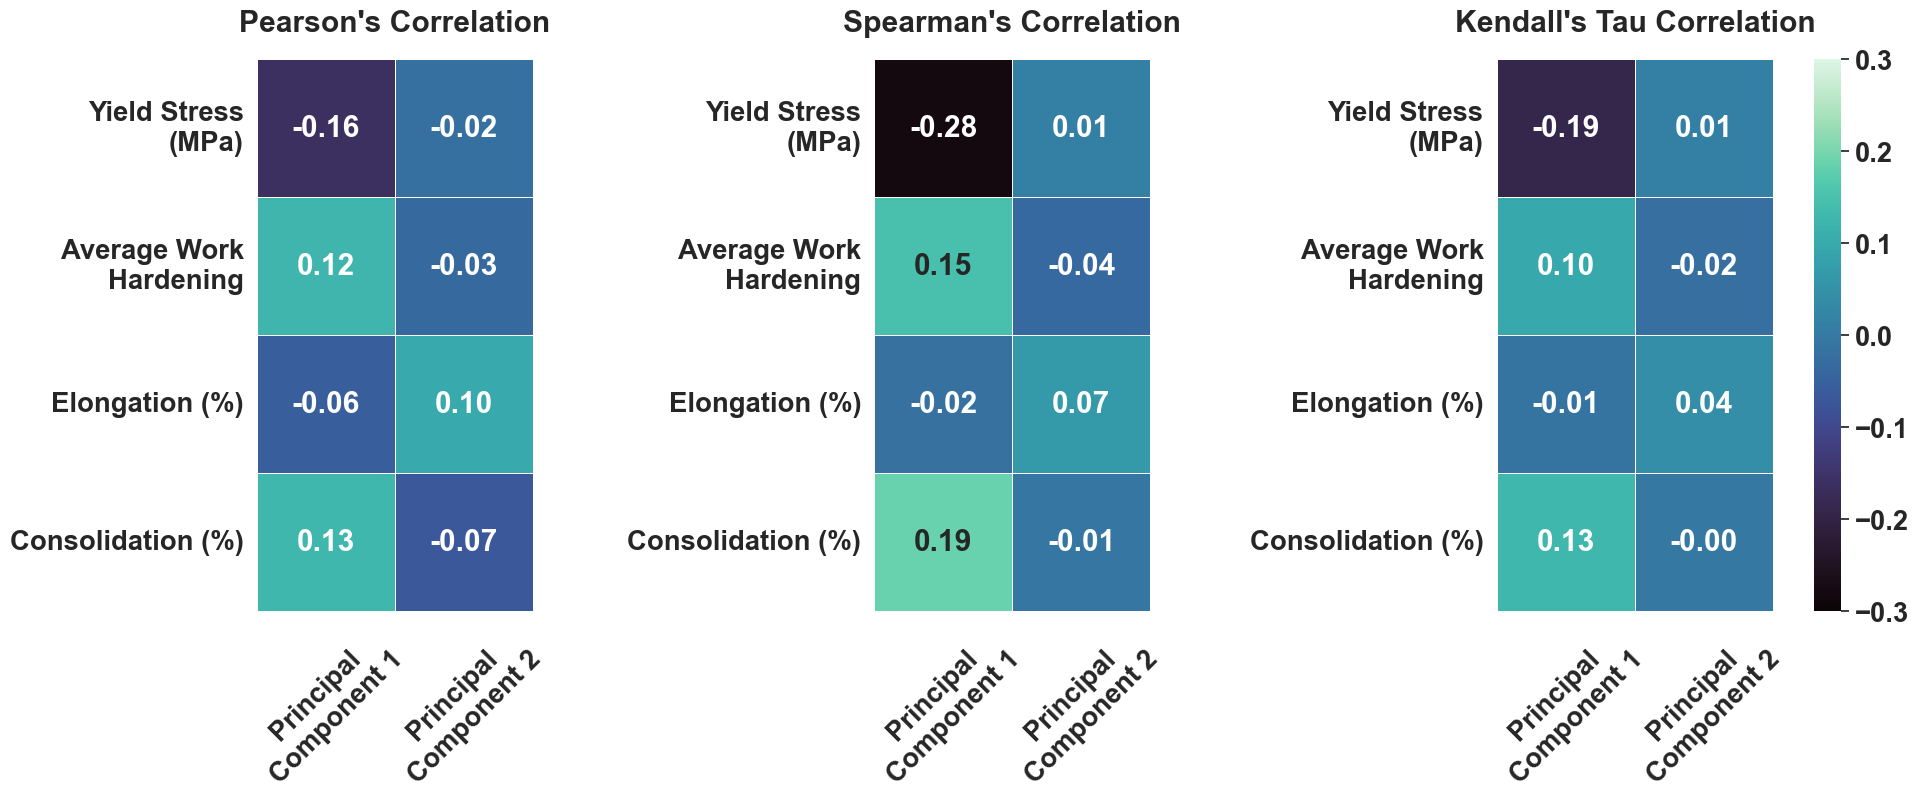

In [14]:
# Plot all 3 correlations together
pearson_corr = in_out_corr(pca_df, output_df, pca_colname, output_var, 'pearson')
spearman_corr = in_out_corr(pca_df, output_df, pca_colname, output_var, 'spearman')
kendall_corr = in_out_corr(pca_df, output_df, pca_colname, output_var, 'kendall')

# List of correlation matrices and their titles
correlation_matrices = [(pearson_corr, "Pearson's Correlation"),
                        (spearman_corr, "Spearman's Correlation"),
                        (kendall_corr, "Kendall's Tau Correlation")]

corr_map(corr_matrices=correlation_matrices, vmin=-0.3, vmax=0.3, step=0.1, c_palette='mako')

# PCA Visualisation

In [15]:
# Filtered dataframe of used rows for PCA
filtered_df = dataset.loc[x_df_index].reset_index(drop=True)
filtered_df

,Material,Laser Power (W),Scanning Speed (mm/s),Layer Thickness (μm),Hatch Spacing (μm),Volumetric energy density (J/mm3),Treatment Information,Yield Stress (MPa),Ultimate Tensile Stress (MPa),Elongation (%),Consolidation (%),Average Work Hardening
0,IN718,180.0,600.0,30.0,150.0,NaN,NaN,804.0,1076.5,16.85,98.67,16.172107
1,IN718,180.0,600.0,30.0,150.0,NaN,NaN,800.5,1075.0,21.05,98.85,13.040380
2,IN718,180.0,600.0,30.0,150.0,NaN,NaN,770.5,1064.5,22.35,99.10,13.154362
3,IN718,180.0,600.0,30.0,150.0,NaN,NaN,772.5,1065.0,25.25,99.12,11.584158
4,IN718,195.0,1200.0,20.0,90.0,90.277778,NaN,NaN,NaN,NaN,95.00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2165,316L,350.0,1700.0,80.0,25.0,102.941176,NaN,366.9,523.7,48.00,98.08,3.266667
2166,316L,100.0,1700.0,55.0,35.0,30.557678,NaN,137.2,165.4,8.00,80.99,3.525000
2167,316L,200.0,1700.0,55.0,35.0,61.115355,NaN,315.9,332.2,9.00,92.21,1.811111
2168,316L,350.0,1400.0,55.0,35.0,129.870130,NaN,398.8,551.2,58.00,99.27,2.627586


In [16]:
# Fetch hex colors
from pylab import *
cmap = cm.get_cmap('mako', 4)    # PiYG

for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    print(matplotlib.colors.rgb2hex(rgba))

#0b0405
#40498e
#38aaac
#def5e5


/var/folders/dr/88_11bqj7nv1y6zj8hs35g3m0000gp/T/ipykernel_53500/2077407163.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('mako', 4)    # PiYG


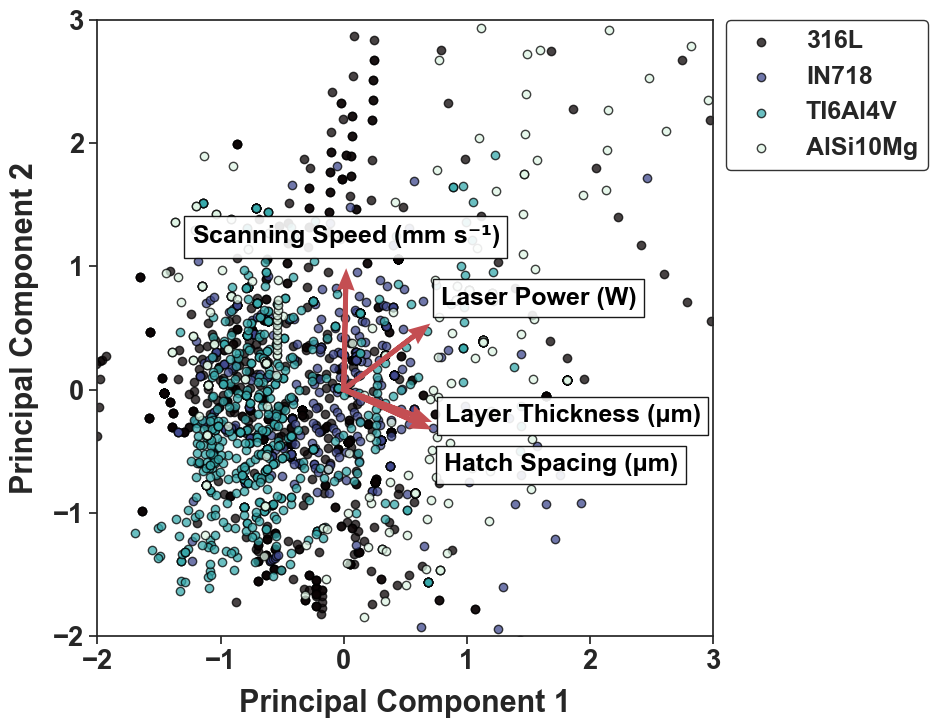

In [20]:
from sklearn.cluster import DBSCAN
from matplotlib.colors import ListedColormap

# Extract features
X = all_df.dropna()
X = X.reset_index(drop=True)
X = X.drop(columns=['cte_min', 'cte_max'])

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA to reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Fit DBSCAN
# eps: Maximum distance between two samples for them to be considered as in the same neighborhood.
# min_samples: Number of samples (or total weight) in a neighborhood for a point to be considered as a core point - includes itself as a point.
# dbscan = DBSCAN(eps=4.5, min_samples=35)
# dbscan.fit(X_pca)

# Define custom colors for the classes
custom_colors = ['#85d9b1', '#3b589a']
cmap_custom = ListedColormap(custom_colors)

# Visualize the clusters
plt.figure(figsize=(8, 8))
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan.labels_, cmap=cmap_custom, alpha=0.5, edgecolors='black')

# Plot the points corresponding to each material
filtered_dfs = [fil_316l, fil_304l, fil_17_4PH, fil_15_5PH, fil_18Ni_300, fil_H13, fil_H11]
materials = ['316L', '304L', '17_4PH', '15_5PH', '18Ni-300', 'H13', 'H11']
colors = ['#3b4cc0', '#7092f3', '#aac7fd', '#dddddd', '#f7b89c', '#e7755b', '#b40426']
markers = ['^', 'v', 's', 'p', 'D', 'H', '*']
# Create a new dataframe with reduced dimensions
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])

for filtered_df, material, color, marker in zip(filtered_dfs, materials, colors, markers):
    filtered_indices = filtered_df.index
    filtered_points = pca_df.loc[filtered_indices]
    if marker == '*':
        plt.scatter(filtered_points['PCA1'], filtered_points['PCA2'], color=color, label=f'{material}', edgecolors='black', marker=marker, s=80)
    else:
        plt.scatter(filtered_points['PCA1'], filtered_points['PCA2'], color=color, label=f'{material}', edgecolors='black', marker=marker, s=50)

# Set plot labels and title
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(fontsize=18, bbox_to_anchor=(1, 1.02), edgecolor='black', loc='upper left')
plt.show()

In [18]:
x_df

,Laser Power (W),Scanning Speed (mm/s),Layer Thickness (μm),Hatch Spacing (μm)
4,180.0,600.0,30.0,150.0
5,180.0,600.0,30.0,150.0
6,180.0,600.0,30.0,150.0
7,180.0,600.0,30.0,150.0
8,195.0,1200.0,20.0,90.0
...,...,...,...,...
2687,350.0,1700.0,80.0,25.0
2688,100.0,1700.0,55.0,35.0
2689,200.0,1700.0,55.0,35.0
2690,350.0,1400.0,55.0,35.0


# Explained Variance

In [18]:
# Consider materials - Uses OneHotEncoder (encoding materials and heat treatment) without Iterative Imputer (missing values)
x_df = dataset[input_var].drop(columns=['Material'])
x_df = x_df.dropna()
x_df_index = x_df.index.to_list()

# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_df)

total_data = len(dataset)
remain_data = x_scaled.shape[0]
dropped_data = len(dataset) - remain_data
print(" Total data = ", total_data, "\n", "Dropped data = ", dropped_data, "\n", "Remaining data = ", remain_data)

 Total data =  2692 
 Dropped data =  522 
 Remaining data =  2170


In [19]:
pca = PCA(n_components=4)  # Adjust the number of components according to your requirement
x_pca = pca.fit_transform(x_scaled)

print("Original shape: {}".format(str(x_scaled.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))

Original shape: (2170, 4)
Reduced shape: (2170, 4)


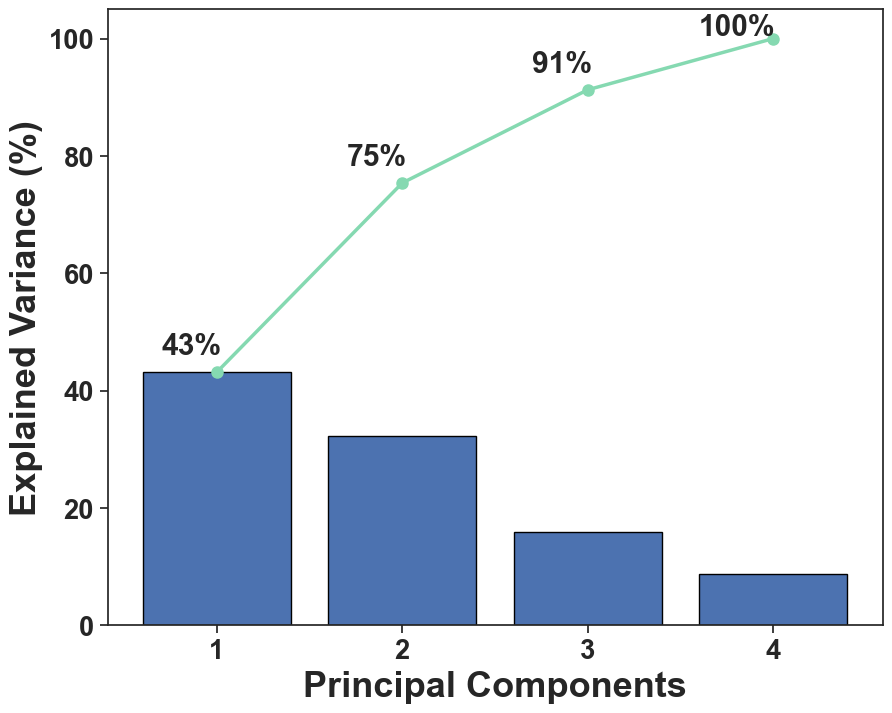

In [20]:
# https://github.com/ChawlaAvi/Daily-Dose-of-Data-Science/blob/main/Machine%20Learning/PCA-Dimensions-Hyperparameter.ipynb

def percent_formatter(x, pos):
    return f"{x*100:.0f}"

init_dimensions = 4
# Variance of individual component 
exp_var = pca.explained_variance_ratio_ 
# Cumulative variance
cumulative_explained_variance = np.cumsum(exp_var) 

fig, ax = plt.subplots(figsize=(10,8))

# Add individual variance bars
plt.bar(range(1, init_dimensions+1), exp_var, align='center',
        label='Individual Component Variance', color = '#4c72b0', edgecolor = 'black')

# Add cumulative variance line
plt.plot(range(1, init_dimensions+1), cumulative_explained_variance, marker="o",
         label='Cumulative Variance', color='#85d9b1', linewidth=2.5, markersize=8)

# Add cumulative variance annotation
for x, y in zip(range(1, init_dimensions), cumulative_explained_variance):
    ax.annotate(f"{round(y * 100):.0f}%", (x - 0.3, y + 0.03))
    
ax.annotate(f"{round(cumulative_explained_variance[3] * 100):.0f}%", (3.6, cumulative_explained_variance[3] + 0.005))

# Add label, title, ticks
plt.xlabel('Principal Components', weight='bold', fontsize = 26)
plt.ylabel('Explained Variance (%)', weight='bold', fontsize = 26)
# plt.title('Cumulative Explained Variance Plot\nfor PCA', fontsize=19, fontweight="bold", pad=20)
plt.xticks(range(1, init_dimensions+1))

# Format y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(percent_formatter))

# Legend location
# plt.legend(loc='best')
plt.show()

In [21]:
cumulative_explained_variance

array([0.43153468, 0.75392605, 0.9126815 , 1.        ])

# PCA Transformation Eigenvector

In [22]:
# Consider materials - Uses OneHotEncoder (encoding materials and heat treatment) without Iterative Imputer (missing values)
x_df = dataset[input_var].drop(columns=['Material'])
x_df = x_df.dropna()
x_df_index = x_df.index.to_list()

# Standardize the features (mean=0 and variance=1)
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_df)

total_data = len(dataset)
remain_data = x_scaled.shape[0]
dropped_data = len(dataset) - remain_data
print(" Total data = ", total_data, "\n", "Dropped data = ", dropped_data, "\n", "Remaining data = ", remain_data)

 Total data =  2692 
 Dropped data =  522 
 Remaining data =  2170


In [23]:
pca = PCA(n_components=2)  # Adjust the number of components according to your requirement
x_pca = pca.fit_transform(x_scaled)

print("Original shape: {}".format(str(x_scaled.shape)))
print("Reduced shape: {}".format(str(x_pca.shape)))

Original shape: (2170, 4)


Reduced shape: (2170, 2)


In [24]:
# Eigenvector of PCA
pca.components_

array([[ 0.58120935,  0.01667761,  0.57725875,  0.57331483],
       [ 0.44277897,  0.83162032, -0.26119222, -0.21007868]])

In [25]:
# https://www.kaggle.com/code/atulanandjha/dimensionality-reduction-i-pca-using-eigenvector
print('Covariance matrix \n')

cov_mat = np.cov(x_scaled.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)
print('Eigenvectors \n%s' %cov_mat)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Covariance matrix 

Eigenvectors 
[[ 1.00046104  0.35951185  0.36610131  0.3573991 ]
 [ 0.35951185  1.00046104 -0.19346503 -0.14853344]
 [ 0.36610131 -0.19346503  1.00046104  0.36595637]
 [ 0.3573991  -0.14853344  0.36595637  1.00046104]]
Eigenvectors 
[[ 0.58120935  0.44277897 -0.67948878 -0.0666144 ]
 [ 0.01667761  0.83162032  0.55495342  0.01249803]
 [ 0.57725875 -0.26119222  0.38911858 -0.66868355]
 [ 0.57331483 -0.21007868  0.28090644  0.74045164]]

Eigenvalues 
[1.72693454 1.29016002 0.34943504 0.63531457]
